In [ ]:
!pip install transformers datasets SentencePiece

In [ ]:
import random
import math
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from transformers import LlamaTokenizer
from datasets import load_dataset

# 1) Initialization

In [ ]:
model_id = "daryl149/llama-2-7b-chat-hf"
tokenizer = LlamaTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

config = {
    'vocab_size': tokenizer.vocab_size,
    'n_layers': 1,
    'embed_dim': 2048,
    'n_heads': 32,
    'n_kv_heads': 8,
    'multiple_of': 64,
    'ffn_dim_multiplier': None,
    'norm_eps': 1e-5,
    'max_batch_size': 16,
    'max_seq_len': 64,
    'device': 'cuda',
}

dataset = load_dataset('glue', 'ax', split='test')
dataset = dataset.select_columns(['premise', 'hypothesis'])

test_set = tokenizer(
    random.sample(dataset['premise'], config['max_batch_size']),
    truncation=True,
    max_length=config['max_seq_len'],
    padding='max_length',
    return_tensors='pt'
)

print(test_set.keys())
print(test_set['input_ids'].size())

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Generating test split:   0%|          | 0/1104 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask'])
torch.Size([16, 64])


# 2) Llama Architecture

[Concept Explained](https://akgeni.medium.com/llama-concepts-explained-summary-a87f0bd61964) | [Llama Github](https://github.com/facebookresearch/llama)

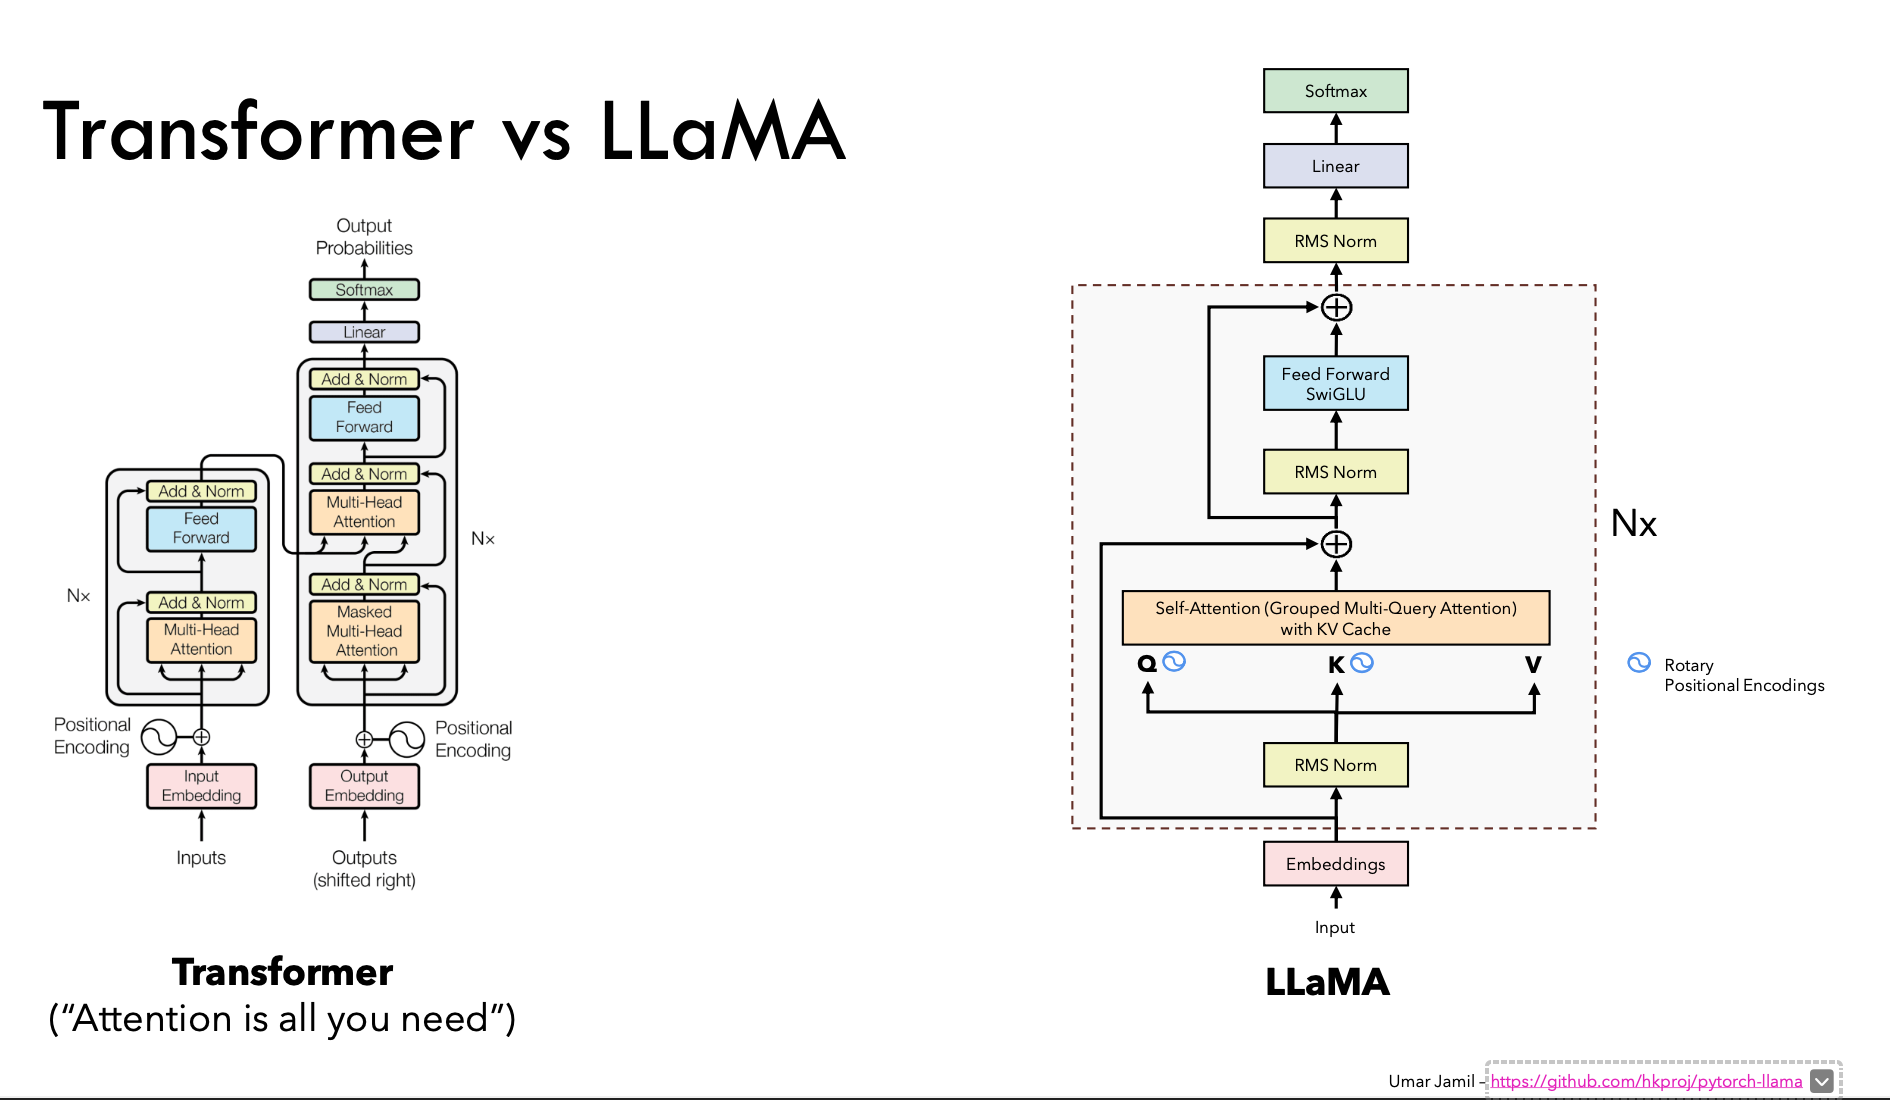

## 2.1 Rotary Embedding

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*Bz0z7dYRTfNo5uGPpAWKtw.png)

### 2.1.1 Implementation

In [ ]:
def precompute_theta_pos_frequencies(head_dim, seq_len, device, theta=10000.0):

    # theta_i = 10000^(-2(i-1)/dim) for i = [1, 2, ... dim/2]
    # (head_dim // 2)
    theta_numerator = torch.arange(0, head_dim, 2).float()
    theta = 1.0 / (theta ** (theta_numerator / head_dim)).to(device)

    # (seq_len)
    m = torch.arange(seq_len, device=device)

    # (seq_len, head_dim // 2)
    freqs = torch.outer(m, theta).float()

    # complex numbers in polar, c = R * exp(m * theta), where R = 1 as follows:
    # (seq_len, head_dim // 2)
    freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_complex

def apply_rotary_embeddings(x, freqs_complex, device):

    # separate the last dimension pairs of two values, representing the real and imaginary
    # two consecutive values will become a single complex number

    # (m, seq_len, num_heads, head_dim // 2, 2)
    x = x.float().reshape(*x.shape[:-1], -1, 2)

    # (m, seq_len, num_heads, head_dim // 2)
    x_complex = torch.view_as_complex(x)

    # (seq_len, head_dim // 2) --> (1, seq_len, 1, head_dim // 2)
    freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)

    # multiply each complex number
    # (m, seq_len, n_heads, head_dim // 2)
    x_rotated = x_complex * freqs_complex

    # convert back to the real number
    # (m, seq_len, n_heads, head_dim/2, 2)
    x_out = torch.view_as_real(x_rotated)

    # (m, seq_len, n_heads, head_dim)
    x_out = x_out.reshape(*x.shape)

    return x_out.type_as(x).to(device)

### 2.1.2 Amendment for Huggingface Model

In [ ]:
old_init = transformers.models.llama.modeling_llama.LlamaRotaryEmbedding.__init__

def ntk_scaled_init(self, dim, max_position_embeddings=2048, base=10000, device=None):
    max_position_embeddings = 16384
    # alpha value
    a = 8
    base = base * a ** (dim / (dim-2))
    old_init(self, dim, max_position_embeddings, base, device)

transformers.models.llama.modeling_llama.LlamaRotaryEmbedding.__init__ = ntk_scaled_init
model_path = "daryl149/llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model_path)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    load_in_8bit=True,
    device_map="auto",
    rope_scaling={"type": 'dynamic', "factor": 2.0},
)

In [ ]:
prompt = '''
You are given this machine learning research paper, please read it carefully and answer the follow up question.

=== BEGIN ===
1 INTRODUCTION

Large language models (LLMs) typically come with a pre-defined context window size. For exam-
ple, inputs to LLaMA models (Touvron et al., 2023) must be fewer than 2048 tokens. This pre-set
context window limit is frequently exceeded in applications such as conducting long conversations,
summarizing long documents, or executing long-term planning. For these applications, LLMs with
longer context windows are preferred. However, training an LLM from scratch with long context
windows requires significant investments. This naturally leads to a question: Can we extend the
context window of an existing pre-trained LLM?

One straightforward approach is to fine-tune an existing pre-trained Transformer with a longer con-
text window. However, empirically, we found that models trained this way adapt to long context
windows very slowly. After training for more than 10000 batches, the effective context window
saw a minimal increase, moving from 2048 to 2560 (Table 4). This suggests that such method is
inefficient for extending to substantially longer context windows.

While certain techniques such as ALiBi (Press et al., 2022) and LeX (Sun et al., 2022) enable length
extrapolation of Transformers, i.e. train on short context windows and inference on longer ones,
many existing pre-trained LLMs, including LLaMA (Touvron et al., 2023), use positional encodings
that have weak extrapolation properties (e.g., RoPE (Su et al., 2021)). Therefore, the applicability
of these techniques for extending the context window sizes of such LLMs remains limited.

In this work, we introduce Position Interpolation to enable context window extensions for certain
existing pre-trained LLMs, including LLaMA. The key idea is, instead of extrapolation, we directly
down-scale the position indices so that the maximum position index matches the previous context
window limit in the pre-training stage. See Figure 1 for an illustration. In other words, to accom-
modate more input tokens, we interpolate the position encodings at neighboring integer positions,
utilizing the fact that position encodings can be applied on non-integer positions, as opposed to
extrapolating outside the trained positions, which may lead to catastrophic values. We verify our
approach theoretically, by showing that the interpolated attention score has a much smaller upper

bound (~ 600x smaller in LLaMA 7B setting) than the extrapolated one, and is thus much more
stable. Therefore, interpolated position encodings are easier for the model to adapt.

Empirically, we found that Position Interpolation is highly effective and efficient, requiring only a
very short period of fine-tuning for the model to fully adapt to greatly extended context windows.
We present experimental results for extending the context window to up to 32768 from the initial
2048 across 7B to 65B LLaMA models using Position Interpolation. Our results show that
=== END OF FILE ===
'''

In [ ]:
generation_config = GenerationConfig(
    temperature=0.0,
    top_k=20,
    repetition_penalty=1.2,
)
print("Prompt token length:", len(tokenizer(prompt, return_tensors="pt")["input_ids"][0]))

def print_predict(prompt):
    prompt = "<|prompter|>" + prompt + "</s><|assistant|>"
    encoding = tokenizer(prompt, return_tensors="pt")
    input_ids = encoding["input_ids"].to("cuda")

    with torch.inference_mode():
        result = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=False,
            output_scores=False,
            max_new_tokens=512)
    decoded_output = tokenizer.decode(result[0][len(input_ids[0]):])
    print(decoded_output)

prompt_question = prompt + "\nPlease give me a brief summary of this research paper in a few bullet points."
print_predict(prompt_question)

prompt_question = prompt + "\nPlease write me the abstract for this paper."
print_predict(prompt_question)

prompt_question = prompt + "\nHow many steps was the model fine tuned for the final results? Give a short answer."
print_predict(prompt_question)

## 2.2 RMSNorm

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*tjjimBzPdzuWW73y444Uzg.jpeg)

RMSNorm is extension of Layer Normalization (LayerNorm). Reason behind using RMSNorm is the computational overhead in LayerNorm. This makes improvements slow and expensive. RMSNorm achieves comparable performance against LayerNorm but reduces the running time by 7%∼64%. The key difference between LayerNorm and RMSNorm is in how the normalization factor is computed:


* Examples:
        Batch 1: (2, 4)
        Batch 2: (6, 8)

* Layer Normalization uses mean and standard deviation across all features.

        Mean: (2 + 4) / 2 = 3.0
        Standard Deviation: sqrt((1/2) * ((2 - 3)^2 + (4 - 3)^2)) = 1.0

        Mean: (6 + 8) / 2 = 7.0
        Standard Deviation: sqrt((1/2) * ((6 - 7)^2 + (8 - 7)^2)) = 1.0

        Batch 1: ((2-3)/1, (4-3)/1)
        Batch 2: ((6-7)/1, (8-7)/1)

* RMSNorm uses the root mean square of the features individually
        RMS: sqrt((2^2 + 4^2) / 2) ≈ 3.16
        RMS: sqrt((6^2 + 8^2) / 2) ≈ 7.07

        Batch 1: ( 2/3.16, 4/3.16)
        Batch 2: ( 6/7.07, 8/7.07 )

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x: torch.Tensor):
        # (m, seq_len, dim) * (m, seq_len, 1) = (m, seq_len, dim)
        # rsqrt: 1 / sqrt(x)
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x: torch.Tensor):
        # weight is a gain parameter used to re-scale the standardized summed inputs
        # (dim) * (m, seq_len, dim) = (m, seq_Len, dim)
        return self.weight * self._norm(x.float()).type_as(x)

## 2.3 KV Caching
![](https://miro.medium.com/v2/resize:fit:1400/1*uyuyOW1VBqmF5Gtv225XHQ.gif)

In [ ]:
class KVCache:
    def __init__(self, max_batch_size, max_seq_len, n_kv_heads, head_dim, device):
        self.cache_k = torch.zeros((max_batch_size, max_seq_len, n_kv_heads, head_dim)).to(device)
        self.cache_v = torch.zeros((max_batch_size, max_seq_len, n_kv_heads, head_dim)).to(device)

    def update(self, batch_size, start_pos, xk, xv):
        self.cache_k[:batch_size, start_pos :start_pos + xk.size(1)] = xk
        self.cache_v[:batch_size, start_pos :start_pos + xv.size(1)] = xv

    def get(self, batch_size, start_pos, seq_len):
        keys = self.cache_k[:batch_size,  :start_pos + seq_len]
        values = self.cache_v[:batch_size, :start_pos + seq_len]
        return keys, values

## 2.4 Grouped Query Attention
![](https://pbs.twimg.com/media/FzjhZk5X0AYAs_-?format=jpg&name=medium)


In [ ]:
def repeat_kv(x, n_rep):

    batch_size, seq_len, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    else:
        # (m, seq_len, n_kv_heads, 1, head_dim)
        # --> (m, seq_len, n_kv_heads, n_rep, head_dim)
        # --> (m, seq_len, n_kv_heads * n_rep, head_dim)
        return (
            x[:, :, :, None, :]
            .expand(batch_size, seq_len, n_kv_heads, n_rep, head_dim)
            .reshape(batch_size, seq_len, n_kv_heads * n_rep, head_dim)
        )

class SelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.n_heads = config['n_heads']
        self.n_kv_heads = config['n_kv_heads']
        self.dim = config['embed_dim']
        self.n_kv_heads = self.n_heads if self.n_kv_heads is None else self.n_kv_heads
        self.n_heads_q = self.n_heads
        self.n_rep = self.n_heads_q // self.n_kv_heads
        self.head_dim = self.dim // self.n_heads

        self.wq = nn.Linear(self.dim, self.n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(self.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(self.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(self.n_heads * self.head_dim, self.dim, bias=False)

        self.cache = KVCache(
            max_batch_size=config['max_batch_size'],
            max_seq_len=config['max_seq_len'],
            n_kv_heads=self.n_kv_heads,
            head_dim=self.head_dim,
            device=config['device']
        )

    def forward(self, x, start_pos, freqs_complex):

        # seq_len is always 1 during inference
        batch_size, seq_len, _ = x.shape

        # (m, seq_len, dim)
        xq = self.wq(x)

        # (m, seq_len, h_kv * head_dim)
        xk = self.wk(x)
        xv = self.wv(x)

        # (m, seq_len, n_heads, head_dim)
        xq = xq.view(batch_size, seq_len, self.n_heads_q, self.head_dim)

        # (m, seq_len, h_kv, head_dim)
        xk = xk.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)
        xv = xv.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)

        # (m, seq_len, num_head, head_dim)
        xq = apply_rotary_embeddings(xq, freqs_complex, device=x.device)

        # (m, seq_len, h_kv, head_dim)
        xk = apply_rotary_embeddings(xk, freqs_complex, device=x.device)

        # replace the entry in the cache
        # start_pos is 0 during training
        self.cache.update(batch_size, start_pos, xk, xv)

        # (m, seq_len, h_kv, head_dim)
        keys, values = self.cache.get(batch_size, start_pos, seq_len)

        # (m, seq_len, h_kv, head_dim) --> (m, seq_len, n_heads, head_dim)
        keys = repeat_kv(keys, self.n_rep)
        values = repeat_kv(values, self.n_rep)

        # (m, n_heads, seq_len, head_dim)
        # seq_len is 1 for xq during inference
        xq = xq.transpose(1, 2)

        # (m, n_heads, seq_len, head_dim)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # (m, n_heads, seq_len_q, head_dim) @ (m, n_heads, head_dim, seq_len) -> (m, n_heads, seq_len_q, seq_len)
        scores = torch.matmul(xq, keys.transpose(2, 3)) / math.sqrt(self.head_dim)

        # (m, n_heads, seq_len_q, seq_len)
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)

        # (m, n_heads, seq_len_q, seq_len) @ (m, n_heads, seq_len, head_dim) -> (m, n_heads, seq_len_q, head_dim)
        output = torch.matmul(scores, values)

        # ((m, n_heads, seq_len_q, head_dim) -> (m, seq_len_q, dim)
        output = (output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1))

        # (m, seq_len_q, dim)
        return self.wo(output)

## 2.5 SwiGlu

![](https://miro.medium.com/v2/resize:fit:596/format:webp/1*W1sg5_qhRfOCWOM1hkXi_Q.png)

In [ ]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def swiglu(x):
    return x * sigmoid(x)

## 2.6 FeedForward Layer and Decoder

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, config):

        super().__init__()

        hidden_dim = 4 * config['embed_dim']
        hidden_dim = int(2 * hidden_dim / 3)

        if config['ffn_dim_multiplier'] is not None:
            hidden_dim = int(config['ffn_dim_multiplier'] * hidden_dim)

        # Round the hidden_dim to the nearest multiple of the multiple_of parameter
        hidden_dim = config['multiple_of'] * ((hidden_dim + config['multiple_of'] - 1) // config['multiple_of'])

        self.w1 = nn.Linear(config['embed_dim'], hidden_dim, bias=False)
        self.w2 = nn.Linear(config['embed_dim'], hidden_dim, bias=False)
        self.w3 = nn.Linear(hidden_dim, config['embed_dim'], bias=False)

    def forward(self, x: torch.Tensor):
        # (m, seq_len, dim) --> (m, seq_len, hidden_dim)
        swish = swiglu(self.w1(x))
        # (m, seq_len, dim) --> (m, seq_len, hidden_dim)
        x_V = self.w2(x)

        # (m, seq_len, hidden_dim)
        x = swish * x_V

        # (m, seq_len, hidden_dim) --> (m, seq_len, dim)
        return self.w3(x)


In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.n_heads = config['n_heads']
        self.dim = config['embed_dim']
        self.head_dim = self.dim // self.n_heads

        self.attention = SelfAttention(config)
        self.feed_forward = FeedForward(config)

        # rms before attention block
        self.attention_norm = RMSNorm(self.dim, eps=config['norm_eps'])

        # rms before  feed forward block
        self.ffn_norm = RMSNorm(self.dim, eps=config['norm_eps'])

    def forward(self, x, start_pos, freqs_complex):

        # (m, seq_len, dim)
        h = x + self.attention.forward(
            self.attention_norm(x), start_pos, freqs_complex)
        # (m, seq_len, dim)
        out = h + self.feed_forward.forward(self.ffn_norm(h))
        return out

In [ ]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.vocab_size = config['vocab_size']
        self.n_layers = config['n_layers']
        self.tok_embeddings = nn.Embedding(self.vocab_size, config['embed_dim'])
        self.head_dim = config['embed_dim'] // config['n_heads']

        self.layers = nn.ModuleList()
        for layer_id in range(config['n_layers']):
            self.layers.append(DecoderBlock(config))

        self.norm = RMSNorm(config['embed_dim'], eps=config['norm_eps'])
        self.output = nn.Linear(config['embed_dim'], self.vocab_size, bias=False)

        self.freqs_complex = precompute_theta_pos_frequencies(
            self.head_dim, config['max_seq_len'] * 2, device=(config['device']))

    def forward(self, tokens, start_pos):
        # (m, seq_len)
        batch_size, seq_len = tokens.shape

        # (m, seq_len) -> (m, seq_len, embed_dim)
        h = self.tok_embeddings(tokens)

        # (seq_len, (embed_dim/n_heads)/2]
        freqs_complex = self.freqs_complex[start_pos:start_pos + seq_len]

        # Consecutively apply all the encoder layers
        # (m, seq_len, dim)
        for layer in self.layers:
            h = layer(h, start_pos, freqs_complex)
        h = self.norm(h)

        # (m, seq_len, vocab_size)
        output = self.output(h).float()
        return output

model = Transformer(config).to(config['device'])
res = model.forward(test_set['input_ids'].to(config['device']), 0)
print(res.size())

x.float().reshape(*x.shape[:-1], -1, 2) torch.Size([16, 64, 32, 32, 2])
x.float().reshape(*x.shape[:-1], -1, 2) torch.Size([16, 64, 8, 32, 2])
torch.Size([16, 64, 32000])


# 3) Generation
[Original Generation Script](https://github.com/facebookresearch/llama/blob/main/llama/generation.py)

In [ ]:
from typing import Optional
import torch
import time
from pathlib import Path
import json
from sentencepiece import SentencePieceProcessor
from tqdm import tqdm

from model import ModelArgs, Transformer

class LLaMA:

    def __init__(self, model: Transformer, tokenizer: SentencePieceProcessor, model_args: ModelArgs):
        self.model = model
        self.tokenizer = tokenizer
        self.args = model_args

    @staticmethod
    def build(checkpoints_dir, tokenizer_path, load_model, max_seq_len, max_batch_size, device):
        prev_time = time.time()
        if load_model:
            checkpoints = sorted(Path(checkpoints_dir).glob("*.pth"))
            assert len(checkpoints) > 0, f"no checkpoint files found in {checkpoints_dir}"
            ckpt_path = checkpoints[0]
            print(f'Loading checkpoint "{ckpt_path}"')
            checkpoint = torch.load(ckpt_path, map_location="cpu")
            print(f"Loaded checkpoint in {time.time() - prev_time:.2f}s")
            prev_time = time.time()
        with open(Path(checkpoints_dir) / "params.json", "r") as f:
            params = json.loads(f.read())

        model_args: ModelArgs = ModelArgs(
            max_seq_len=max_seq_len,
            max_batch_size=max_batch_size,
            device=device,
            **params
        )

        tokenizer = SentencePieceProcessor()
        tokenizer.load(tokenizer_path)
        model_args.vocab_size = tokenizer.vocab_size()

        if device == "cuda":
            torch.set_default_tensor_type(torch.cuda.HalfTensor)
        else:
            torch.set_default_tensor_type(torch.BFloat16Tensor)

        model = Transformer(model_args).to(device)

        if load_model:
            # The only unmatched key in the checkpoint is rope.freqs. Remove it
            del checkpoint['rope.freqs']
            model.load_state_dict(checkpoint, strict=True)
            print(f"Loaded state dict in {time.time() - prev_time:.2f}s")

        return LLaMA(model, tokenizer, model_args)

    def text_completion(self, prompts, temperature=0.6, top_p=0.9, max_gen_len=None):
        if max_gen_len is None:
            max_gen_len = self.args.max_seq_len - 1

        # Convert each prompt into tokens
        prompt_tokens = [
            self.tokenizer.encode(prompt, out_type=int, add_bos=True, add_eos=False)
                for prompt in prompts
        ]
        batch_size = len(prompt_tokens)
        max_prompt_len = max(len(prompt) for prompt in prompt_tokens)
        total_len = min(self.args.max_seq_len, max_gen_len + max_prompt_len)

        # create full length tensor and fill with encoded tokens
        pad_id = self.tokenizer.pad_id()
        tokens = torch.full((batch_size, total_len), pad_id, dtype=torch.long, device=device)
        for k, t in enumerate(prompt_tokens):
            tokens[k, :len(t)] = torch.tensor(t, dtype=torch.long, device=device)

        eos_reached = torch.tensor([False] * batch_size, device=device)
        # True if the token is a prompt token, False otherwise
        prompt_tokens_mask = tokens != pad_id
        cur_iterator = tqdm(range(1, total_len), desc="Generating tokens")

        # start from 1, 2, 3... or min_prompt_len
        # shorter sentence is padded to same size
        # thus we can only start from the shortest prompt
        # use xformers (refer mistral), to combine all prompt into one
        for cur_pos in cur_iterator:
            with torch.no_grad():
                logits = self.model.forward(tokens[:, cur_pos-1:cur_pos], cur_pos)
            if temperature > 0:
                # temperature is applied before the softmax
                probs = torch.softmax(logits[:, -1] / temperature, dim=-1)
                next_token = self._sample_top_p(probs, top_p)
            else:
                # select the token with the max probability
                next_token = torch.argmax(logits[:, -1], dim=-1)

            next_token = next_token.reshape(-1)
            # use original prompt token if not mask, else use predicted
            next_token = torch.where(
                prompt_tokens_mask[:, cur_pos],
                tokens[:, cur_pos],
                next_token
            )

            tokens[:, cur_pos] = next_token
            # eos is reached only if we found an EOS token for a padding position
            eos_reached |= (~prompt_tokens_mask[:, cur_pos]) & (next_token == self.tokenizer.eos_id)

            # break if eos reached for all batch
            if all(eos_reached):
                break

        out_tokens = []
        out_text = []
        for prompt_index, current_prompt_tokens in enumerate(tokens.tolist()):
            # drop every token after eos
            if self.tokenizer.eos_id in current_prompt_tokens:
                eos_idx = current_prompt_tokens.index(self.tokenizer.eos_id)
                current_prompt_tokens = current_prompt_tokens[:eos_idx]
            out_tokens.append(current_prompt_tokens)
            out_text.append(self.tokenizer.decode(current_prompt_tokens))
        return (out_tokens, out_text)

    def _sample_top_p(self, probs, p):
        # (m, vocab_size)
        probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)
        probs_sum = torch.cumsum(probs_sort, dim=-1)

        # substract "probs_sort" shifts the cumulative sum by 1 position to the right
        mask = probs_sum - probs_sort > p

        # set zero to all tokens if not selected by top P
        probs_sort[mask] = 0.0

        # redistribute the probabilities so that they sum up to 1.
        probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))

        # sample a token (its index) from the top p distribution
        next_token = torch.multinomial(probs_sort, num_samples=1)

        # get the token position in the vocab corresponding to the sampled index
        next_token = torch.gather(probs_idx, -1, next_token)
        return next_token

if __name__ == '__main__':
    torch.manual_seed(0)

    allow_cuda = False
    device = 'cuda' if torch.cuda.is_available() and allow_cuda else 'cpu'

    prompts = [
        "Simply put, the theory of relativity states that ",
        "If Google was an Italian company founded in Milan, it would",
        # Few shot promt
        """Translate English to French:
        sea otter => loutre de mer
        peppermint => menthe poivrée
        plush girafe => girafe peluche
        cheese =>""",
        # Zero shot prompt
        """Tell me if the following person is actually Doraemon disguised as human:
        Name: Kean
        Decision:
        """
    ]

    model = LLaMA.build(
        checkpoints_dir='llama-2-7b/',
        tokenizer_path='tokenizer.model',
        load_model=True,
        max_seq_len=1024,
        max_batch_size=len(prompts),
        device=device
    )

    out_tokens, out_texts = (model.text_completion(prompts, max_gen_len=64))
    assert len(out_texts) == len(prompts)
    for i in range(len(out_texts)):
        print(f'{out_texts[i]}')
        print('-' * 50)